In [2]:
import os
import os.path as osp
root_dir = osp.dirname(osp.dirname(os.getcwd()))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.rc('axes', axisbelow=True)
plt.rcParams.update({'figure.autolayout': True})

species2idx = {
    "Oleispira antarctica": 0,
    "Caenorhabditis elegans": 1,
    "Arabidopsis thaliana": 2,
    "Drosophila melanogaster": 3,
    "Danio rerio": 4,
    "Saccharomyces cerevisiae": 5,
    "Bacillus subtilis": 6,
    "Escherichia coli": 7,
    "Homo sapiens": 8,
    "Mus musculus": 9,
    "Geobacillus stearothermophilus": 10,
    "Picrophilus torridus": 11,
    "Thermus thermophilus": 12
}
cm = plt.get_cmap('gist_rainbow')

In [11]:
meta_file = osp.join(root_dir, 'data', 'collation', 'DeepSTABp', 'lysate.csv')

meta = np.loadtxt(meta_file, skiprows=1, delimiter=',', dtype=np.str_)
print(meta)

meta_accessions = meta[:,0]
meta_Tm = meta[:,1].astype(np.float_)
meta_ogts = meta[:,2].astype(np.float_)
meta_species = meta[:,3]

# accession_groups = []
# for ogt in np.unique(ogts):
#     accession_groups.append(accessions[ogts == ogt])

[['A0A023PXQ4' '52.4077619837866' '32.0' 'Saccharomyces cerevisiae']
 ['A0A023T4K3' '37.96367254303041' '20.0' 'Caenorhabditis elegans']
 ['A0A023T778' '54.99367375656585' '37.0' 'Mus musculus']
 ...
 ['Z4YL87' '54.9920512273696' '37.0' 'Mus musculus']
 ['Z4YLI8' '48.64740428630003' '37.0' 'Mus musculus']
 ['Z4YML9' '53.356698003754886' '37.0' 'Mus musculus']]


In [13]:
save = False

In [14]:
train_entries = np.loadtxt('training_entries.txt', dtype=np.str_)
valid_entries = np.loadtxt('validation_entries.txt', dtype=np.str_)

print(f'Training\t: {train_entries.shape}')
print(f'Validation\t: {valid_entries.shape}')

print(f'Total\t\t: {train_entries.size+valid_entries.size}\n')

Training	: (15872,)
Validation	: (4383,)
Total		: 20255



In [15]:
### LINEAR REGRESSION

########################################################################
# get OGT and Tm
########################################################################

ogts = []
tms = []
for accession in train_entries:
    accession = accession.split('-')[0]
    try:
        ogts.append(meta_ogts[meta_accessions==accession][0])
        tms.append(meta_Tm[meta_accessions==accession][0])
    except IndexError:
        print(accession)
        print(meta_accessions==accession)
ogts = np.array(ogts)
tms = np.array(tms)

print(f'OGTs\t\t: {ogts.shape}')
print(f'Tms\t\t: {tms.shape}\t')

########################################################################
# linear regression
########################################################################

lin_model = LinearRegression().fit(ogts.reshape(-1,1), tms)

print(f'r2: {lin_model.score(ogts.reshape(-1,1), tms)}')

########################################################################
# plot
########################################################################

fig, ax = plt.subplots(
    1,2, sharex=True, sharey=True, figsize=(5.5,3.1), layout='constrained'
)
ax = ax.flatten()
# fig.suptitle()

for i, set_name in enumerate(['training', 'validation']):
    
    alpha = 0.6 if set_name == 'training' else 0.8
    entries = train_entries if set_name == 'training' else valid_entries

    species = []
    ogts = []
    tms = []
    for accession in entries:
        accession = accession.split('-')[0]
        try:
            species.append(meta_species[meta_accessions==accession][0])
            ogts.append(meta_ogts[meta_accessions==accession][0])
            tms.append(meta_Tm[meta_accessions==accession][0])
        except IndexError:
            print(accession)
            print(meta_accessions==accession)
    species = np.array(species)
    ogts = np.array(ogts)
    tms = np.array(tms)

    # print(f'species\t\t: {species.shape}')
    # print(f'OGTs\t\t: {ogts.shape}')
    # print(f'Tms\t\t: {tms.shape}\t')

    
    true = tms
    pred = lin_model.predict(ogts.reshape(-1,1))

    for sp in np.unique(species):
        ax[i].scatter(
            true[species==sp], pred[species==sp], marker='x',
            s=0.1, alpha=alpha, zorder=3,
            # c=f'C{list(model_names).index(model)}'
            color=cm(species2idx[sp]/len(species2idx)),
        )

    # if i%2 != 0:
    #     sns.kdeplot(
    #         x=true, y=pred[1:],
    #         levels=10,
    #         fill=True, alpha=0.2, zorder=2,
    #         color=f'C{list(model_names).index(model)}',
    #         ax=ax[i],
    #     )

    ax[i].plot(
        np.linspace(30,95), np.linspace(30,95),
        '--', c='gray', alpha=1, zorder=4
    )

    ax[i].set_title(f'{set_name}')
    ax[i].set_xlabel(r'true $T_m$')
    if i%2 == 0:
        ax[i].set_ylabel(r'predicted $T_m$')
    # ax[i].grid()
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelbottom=True)

    # ax[i].xaxis.tick_bottom()

    # ax[i].set_xlim(0, df['epoch'].max())
    # ax[i].set_ylim(metric_limits[metric])

if save:
    plt.savefig(
    f'true_vs_pred-theoretical_limit.png',
    dpi=300
)
plt.show()
plt.close()

OGTs		: (15872,)
Tms		: (15872,)	
r2: 0.6426674449620291


OGTs		: (15872,)
Tms		: (15872,)	
[[  37. 1369.]
 [  37. 1369.]
 [  37. 1369.]
 ...
 [  37. 1369.]
 [  37. 1369.]
 [  20.  400.]]
r2: 0.7673435707044238


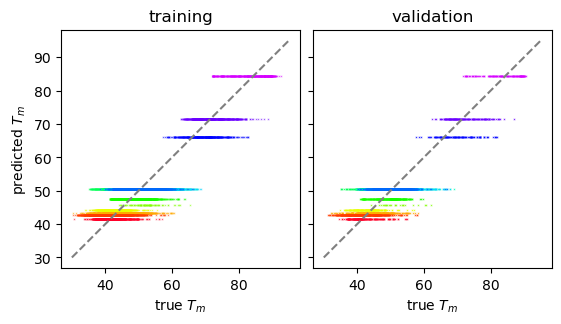

In [23]:
### QUADRATIC REGRESSION

########################################################################
# get OGT and Tm
########################################################################

ogts = []
tms = []
for accession in train_entries:
    accession = accession.split('-')[0]
    try:
        ogts.append(meta_ogts[meta_accessions==accession][0])
        tms.append(meta_Tm[meta_accessions==accession][0])
    except IndexError:
        print(accession)
        print(meta_accessions==accession)
ogts = np.array(ogts)
tms = np.array(tms)

print(f'OGTs\t\t: {ogts.shape}')
print(f'Tms\t\t: {tms.shape}\t')

########################################################################
# linear regression
########################################################################

input = np.hstack((ogts.reshape(-1,1), ogts.reshape(-1,1)**2))

# print(input)

lin_model = LinearRegression().fit(input, tms)
print(f'r2: {lin_model.score(input, tms)}')

########################################################################
# plot
########################################################################

fig, ax = plt.subplots(
    1,2, sharex=True, sharey=True, figsize=(5.5,3.1), layout='constrained'
)
ax = ax.flatten()
# fig.suptitle()

for i, set_name in enumerate(['training', 'validation']):
    
    alpha = 0.6 if set_name == 'training' else 0.8
    entries = train_entries if set_name == 'training' else valid_entries

    species = []
    ogts = []
    tms = []
    for accession in entries:
        accession = accession.split('-')[0]
        try:
            species.append(meta_species[meta_accessions==accession][0])
            ogts.append(meta_ogts[meta_accessions==accession][0])
            tms.append(meta_Tm[meta_accessions==accession][0])
        except IndexError:
            print(accession)
            print(meta_accessions==accession)
    species = np.array(species)
    ogts = np.array(ogts)
    tms = np.array(tms)

    # print(f'species\t\t: {species.shape}')
    # print(f'OGTs\t\t: {ogts.shape}')
    # print(f'Tms\t\t: {tms.shape}\t')

    
    true = tms
    pred = lin_model.predict(
        np.hstack((ogts.reshape(-1,1), ogts.reshape(-1,1)**2))
    )

    for sp in np.unique(species):
        ax[i].scatter(
            true[species==sp], pred[species==sp], marker='x',
            s=0.1, alpha=alpha, zorder=3,
            # c=f'C{list(model_names).index(model)}'
            color=cm(species2idx[sp]/len(species2idx)),
        )

    # if i%2 != 0:
    #     sns.kdeplot(
    #         x=true, y=pred[1:],
    #         levels=10,
    #         fill=True, alpha=0.2, zorder=2,
    #         color=f'C{list(model_names).index(model)}',
    #         ax=ax[i],
    #     )

    ax[i].plot(
        np.linspace(30,95), np.linspace(30,95),
        '--', c='gray', alpha=1, zorder=4
    )

    ax[i].set_title(f'{set_name}')
    ax[i].set_xlabel(r'true $T_m$')
    if i%2 == 0:
        ax[i].set_ylabel(r'predicted $T_m$')
    # ax[i].grid()
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelbottom=True)

    # ax[i].xaxis.tick_bottom()

    # ax[i].set_xlim(0, df['epoch'].max())
    # ax[i].set_ylim(metric_limits[metric])

if save:
    plt.savefig(
    f'true_vs_pred-theoretical_limit.png',
    dpi=300
)
plt.show()
plt.close()

OGTs		: (15872,)
Tms		: (15872,)	
r2: 0.7681474883367888


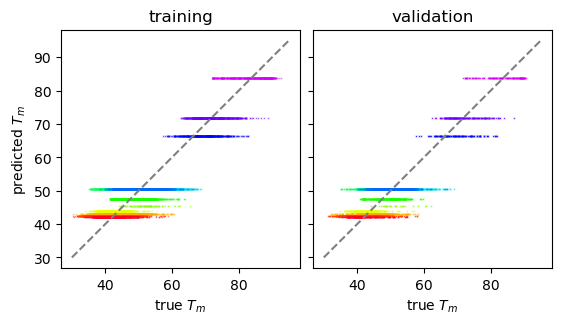

In [24]:
### CUBIC REGRESSION

########################################################################
# get OGT and Tm
########################################################################

ogts = []
tms = []
for accession in train_entries:
    accession = accession.split('-')[0]
    try:
        ogts.append(meta_ogts[meta_accessions==accession][0])
        tms.append(meta_Tm[meta_accessions==accession][0])
    except IndexError:
        print(accession)
        print(meta_accessions==accession)
ogts = np.array(ogts)
tms = np.array(tms)

print(f'OGTs\t\t: {ogts.shape}')
print(f'Tms\t\t: {tms.shape}\t')

########################################################################
# linear regression
########################################################################

input = np.hstack(
    (ogts.reshape(-1,1), ogts.reshape(-1,1)**2, ogts.reshape(-1,1)**3)
)

# print(input)

lin_model = LinearRegression().fit(input, tms)
print(f'r2: {lin_model.score(input, tms)}')

########################################################################
# plot
########################################################################

fig, ax = plt.subplots(
    1,2, sharex=True, sharey=True, figsize=(5.5,3.1), layout='constrained'
)
ax = ax.flatten()
# fig.suptitle()

for i, set_name in enumerate(['training', 'validation']):
    
    alpha = 0.6 if set_name == 'training' else 0.8
    entries = train_entries if set_name == 'training' else valid_entries

    species = []
    ogts = []
    tms = []
    for accession in entries:
        accession = accession.split('-')[0]
        try:
            species.append(meta_species[meta_accessions==accession][0])
            ogts.append(meta_ogts[meta_accessions==accession][0])
            tms.append(meta_Tm[meta_accessions==accession][0])
        except IndexError:
            print(accession)
            print(meta_accessions==accession)
    species = np.array(species)
    ogts = np.array(ogts)
    tms = np.array(tms)

    # print(f'species\t\t: {species.shape}')
    # print(f'OGTs\t\t: {ogts.shape}')
    # print(f'Tms\t\t: {tms.shape}\t')

    
    true = tms
    pred = lin_model.predict(np.hstack(
        (ogts.reshape(-1,1), ogts.reshape(-1,1)**2, ogts.reshape(-1,1)**3)
    ))

    for sp in np.unique(species):
        ax[i].scatter(
            true[species==sp], pred[species==sp], marker='x',
            s=0.1, alpha=alpha, zorder=3,
            # c=f'C{list(model_names).index(model)}'
            color=cm(species2idx[sp]/len(species2idx)),
        )

    # if i%2 != 0:
    #     sns.kdeplot(
    #         x=true, y=pred[1:],
    #         levels=10,
    #         fill=True, alpha=0.2, zorder=2,
    #         color=f'C{list(model_names).index(model)}',
    #         ax=ax[i],
    #     )

    ax[i].plot(
        np.linspace(30,95), np.linspace(30,95),
        '--', c='gray', alpha=1, zorder=4
    )

    ax[i].set_title(f'{set_name}')
    ax[i].set_xlabel(r'true $T_m$')
    if i%2 == 0:
        ax[i].set_ylabel(r'predicted $T_m$')
    # ax[i].grid()
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelbottom=True)

    # ax[i].xaxis.tick_bottom()

    # ax[i].set_xlim(0, df['epoch'].max())
    # ax[i].set_ylim(metric_limits[metric])

if save:
    plt.savefig(
    f'true_vs_pred-theoretical_limit.png',
    dpi=300
)
plt.show()
plt.close()

OGTs		: (15872,)
Tms		: (15872,)	
r2: 0.7693579523332073


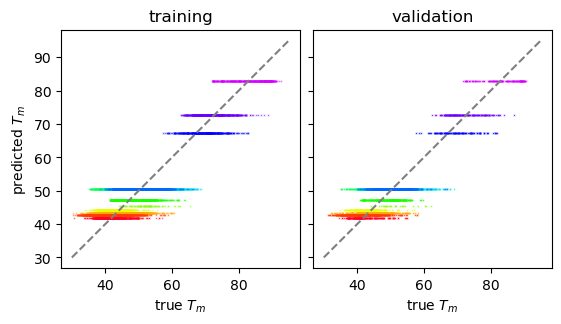

In [25]:
### 4th-order REGRESSION

########################################################################
# get OGT and Tm
########################################################################

ogts = []
tms = []
for accession in train_entries:
    accession = accession.split('-')[0]
    try:
        ogts.append(meta_ogts[meta_accessions==accession][0])
        tms.append(meta_Tm[meta_accessions==accession][0])
    except IndexError:
        print(accession)
        print(meta_accessions==accession)
ogts = np.array(ogts)
tms = np.array(tms)

print(f'OGTs\t\t: {ogts.shape}')
print(f'Tms\t\t: {tms.shape}\t')

########################################################################
# linear regression
########################################################################

input = np.hstack(
    (ogts.reshape(-1,1), ogts.reshape(-1,1)**2, ogts.reshape(-1,1)**3, ogts.reshape(-1,1)**4)
)

# print(input)

lin_model = LinearRegression().fit(input, tms)
print(f'r2: {lin_model.score(input, tms)}')

########################################################################
# plot
########################################################################

fig, ax = plt.subplots(
    1,2, sharex=True, sharey=True, figsize=(5.5,3.1), layout='constrained'
)
ax = ax.flatten()
# fig.suptitle()

for i, set_name in enumerate(['training', 'validation']):
    
    alpha = 0.6 if set_name == 'training' else 0.8
    entries = train_entries if set_name == 'training' else valid_entries

    species = []
    ogts = []
    tms = []
    for accession in entries:
        accession = accession.split('-')[0]
        try:
            species.append(meta_species[meta_accessions==accession][0])
            ogts.append(meta_ogts[meta_accessions==accession][0])
            tms.append(meta_Tm[meta_accessions==accession][0])
        except IndexError:
            print(accession)
            print(meta_accessions==accession)
    species = np.array(species)
    ogts = np.array(ogts)
    tms = np.array(tms)

    # print(f'species\t\t: {species.shape}')
    # print(f'OGTs\t\t: {ogts.shape}')
    # print(f'Tms\t\t: {tms.shape}\t')

    
    true = tms
    pred = lin_model.predict(np.hstack(
        (ogts.reshape(-1,1), ogts.reshape(-1,1)**2, ogts.reshape(-1,1)**3, ogts.reshape(-1,1)**4)
    ))

    for sp in np.unique(species):
        ax[i].scatter(
            true[species==sp], pred[species==sp], marker='x',
            s=0.1, alpha=alpha, zorder=3,
            # c=f'C{list(model_names).index(model)}'
            color=cm(species2idx[sp]/len(species2idx)),
        )

    # if i%2 != 0:
    #     sns.kdeplot(
    #         x=true, y=pred[1:],
    #         levels=10,
    #         fill=True, alpha=0.2, zorder=2,
    #         color=f'C{list(model_names).index(model)}',
    #         ax=ax[i],
    #     )

    ax[i].plot(
        np.linspace(30,95), np.linspace(30,95),
        '--', c='gray', alpha=1, zorder=4
    )

    ax[i].set_title(f'{set_name}')
    ax[i].set_xlabel(r'true $T_m$')
    if i%2 == 0:
        ax[i].set_ylabel(r'predicted $T_m$')
    # ax[i].grid()
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelbottom=True)

    # ax[i].xaxis.tick_bottom()

    # ax[i].set_xlim(0, df['epoch'].max())
    # ax[i].set_ylim(metric_limits[metric])

if save:
    plt.savefig(
    f'true_vs_pred-theoretical_limit.png',
    dpi=300
)
plt.show()
plt.close()